# Pan01 Sea Ice Concentration

In [2]:
from intake import cat
from xarray import DataTree, map_over_datasets

from dask.distributed import Client

import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import glob

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as lines

import cmocean as cm
import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39637/status,
Dashboard: /proxy/39637/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43857,Workers: 0
Dashboard: /proxy/39637/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35425,Total threads: 1
Dashboard: /proxy/33419/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:36917,


2025-07-18 13:37:55,311 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,318 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,322 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,328 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,334 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,340 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,345 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,351 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,356 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,362 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,367 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,373 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,379 - distributed.nanny - WARNING - Restarting worker
2025-07-18 13:37:55,386 - distributed.

## Importing the data
Giving intake a chance for once, hope I don't regret it

In [4]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

pathsC_ice = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ice_month.nc'))
pathsM_ice = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ice_month.nc'))

In [5]:
#Time variant variables
def preprocess_1(ds):
    ds = ds['siconc']
    return ds

cont_ice = xr.open_mfdataset(pathsC_ice, preprocess = preprocess_1, chunks = 'auto')
melt_ice = xr.open_mfdataset(pathsM_ice, preprocess = preprocess_1, chunks = 'auto')

In [6]:
#Time variant variables
def preprocess_2(ds):
    ds = ds['so']
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess_2, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess_2, chunks = 'auto')

In [7]:
#Time slicing
cont_ice = cont_ice.sel(time=slice('2001-01-01','2010-12-31'))
melt_ice = melt_ice.sel(time=slice('2001-01-01','2010-12-31'))

cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [8]:
#Time invariant variables
areaC = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello']

## Wrangling

In [14]:
sic_args = {
    "cice5": { #cice5 is part of ACCESS-OM2
        "expt": "01deg_jra55v13_ryf9091",
        "variable": "aice_m",
        "decode_coords": False
    },
    "sis2": { #sis2 is used for testing MOM6
        "expt": "OM4_025.JRA_RYF",
        "variable": "siconc",
        "decode_coords": False
    },
    #In the future, we will add a CICE6 option (i.e. the future ACCESS-OM3)
}

area_variable = {
    "cice5": "area_t" ,
    "sis2": "areacello"
}

geo_variables = {
    "cice5":['geolon_t', 'geolat_t'] ,
    "sis2": ['geolon', 'geolat']
}

## Calculate Sea Ice Area
Sea ice area is the circumpolar sum of sea ice concentration multiplied by the area of each grid cell. By convention (and because lower concentrations are not accurate when measured through remote sensing) concentrations below 0.15 are not included

In [9]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

Not sure if using this?

## Sea Ice Concentration

In [11]:
sic_C = cont_ice['siconc']
sic_M = melt_ice['siconc']

In [12]:
sic_C

<xarray.DataArray 'siconc' (time: 120, yT: 845, xT: 3600)> Size: 1GB
dask.array<getitem, shape=(120, 845, 3600), dtype=float32, chunksize=(2, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yT       (yT) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          0-1
    long_name:      ice concentration
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [13]:
areaC

<xarray.DataArray 'areacello' (yh: 845, xh: 3600)> Size: 12MB
[3042000 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
Attributes:
    units:          m2
    long_name:      Ocean Grid-Cell Area
    cell_methods:   area:sum yh:sum xh:sum time: point
    standard_name:  cell_area

### Mapping

In [10]:
sic_map_C = sic_C.mean(dim='time')
sic_map_M = sic_M.mean(dim='time')

In [11]:
sic_map_anom = sic_map_M - sic_map_C
sic_map_anom

<xarray.DataArray 'siconc' (yT: 845, xT: 3600)> Size: 12MB
dask.array<sub, shape=(845, 3600), dtype=float32, chunksize=(845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xT       (xT) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yT       (yT) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14

In [14]:
sic_map_anom = sic_map_anom.load()

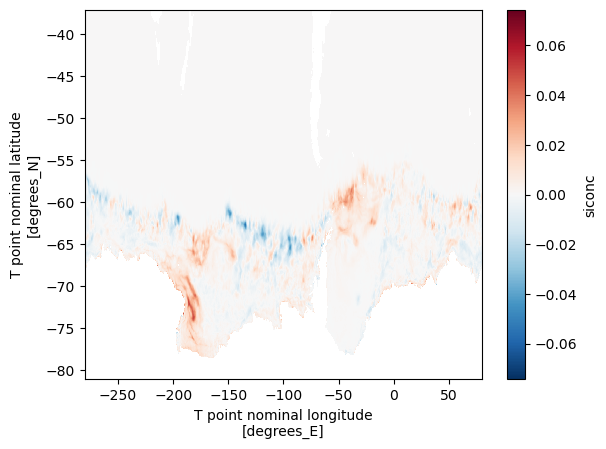

In [15]:
sic_map_anom.plot()

In [16]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [17]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

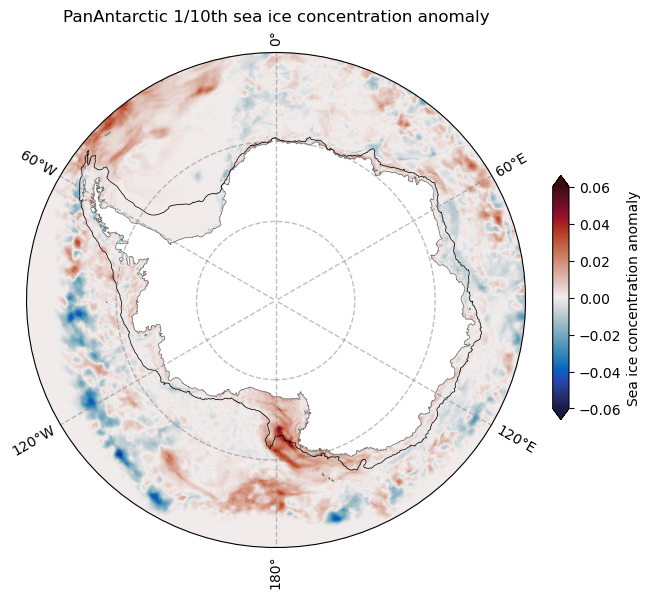

In [19]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
sic_map_anom.plot(
    x="xT",
    y="yT",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea ice concentration anomaly", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th sea ice concentration anomaly");

### Time series

In [31]:
# Corrected area

var_C = cont['so'].isel(time=0,z_l=0)
var_M = melt['so'].isel(time=0,z_l=0)

areaC_corr = areaC*(var_C*0 +1)
areaM_corr = areaM*(var_M*0 +1)

In [32]:
areaC_corr

<xarray.DataArray (yh: 845, xh: 3600)> Size: 12MB
dask.array<multiply, shape=(845, 3600), dtype=float32, chunksize=(242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
    z_l      float64 8B 0.5413
    time     object 8B 2001-01-16 12:00:00

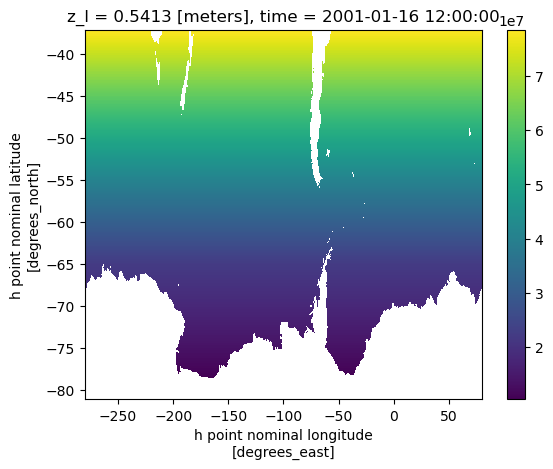

In [33]:
# Checking
areaC_corr.plot()

In [ ]:
# Spatial average
sic_C_time = (areaC_corr * sic_C).sum(['xh', 'yh']) / areaC_corr.sum(['xh', 'yh'])
sic_M_time = (areaM_corr * sic_M).sum(['xh', 'yh']) / areaM_corr.sum(['xh', 'yh'])

In [ ]:
sic_C_time

In [ ]:
sic_C_time = sic_C_time.load()

In [ ]:
sic_M_time = sic_M_time.load()

In [ ]:
sic_C_time.plot(label="Control")
sic_M_time.plot(label="Perturbation")
#plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Sea Ice Concentration Anomaly")
plt.legend(loc="lower left")
plt.title("Pan01 Time Series of Sea Ice Concentration Anomaly")

In [1]:
sic_C

NameError: name 'sic_C' is not defined